#Predicting Car Prices

###by Charles Fleury, guided by a project from Dataquest

In this project, I use a [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data) of technical aspects of cars in 1985 to predict their price using machine learning and more precisely the k-nearest neighbors model. The documentation of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/automobile).

After importing our main libraries, we'll add the missing column names to the dataset, based on the documentation.

In [1]:
import pandas as pd
import numpy as np

In [2]:
column_names = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration", "num_doors", "body_style", "drive_wheels", "engine_location", "wheel_base", "length", "width", "height", "curb_weight", "engine_type", "num_cylinders", "engine_size", "fuel_system", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]
cars = pd.read_csv("imports-85.data", header=0, names=column_names)
print(cars.head())

   symboling normalized_losses         make fuel_type aspiration num_doors  \
0          3                 ?  alfa-romero       gas        std       two   
1          1                 ?  alfa-romero       gas        std       two   
2          2               164         audi       gas        std      four   
3          2               164         audi       gas        std      four   
4          2                 ?         audi       gas        std       two   

    body_style drive_wheels engine_location  wheel_base  ...    engine_size  \
0  convertible          rwd           front        88.6  ...            130   
1    hatchback          rwd           front        94.5  ...            152   
2        sedan          fwd           front        99.8  ...            109   
3        sedan          4wd           front        99.4  ...            136   
4        sedan          fwd           front        99.8  ...            136   

   fuel_system  bore  stroke compression_ratio horsepowe

##Data cleaning

First, we can see that some values are noted "?". We'll start by changing these values to null.

In [3]:
cars = cars.replace("?", np.nan)
print(cars.head())
print(cars.info())

   symboling normalized_losses         make fuel_type aspiration num_doors  \
0          3               NaN  alfa-romero       gas        std       two   
1          1               NaN  alfa-romero       gas        std       two   
2          2               164         audi       gas        std      four   
3          2               164         audi       gas        std      four   
4          2               NaN         audi       gas        std       two   

    body_style drive_wheels engine_location  wheel_base  ...    engine_size  \
0  convertible          rwd           front        88.6  ...            130   
1    hatchback          rwd           front        94.5  ...            152   
2        sedan          fwd           front        99.8  ...            109   
3        sedan          4wd           front        99.4  ...            136   
4        sedan          fwd           front        99.8  ...            136   

   fuel_system  bore  stroke compression_ratio horsepowe

In [4]:
print(cars["normalized_losses"].isnull().sum())

40


We can see that the "normalized_losses" column has 40 null values out of 204 entries. This column is a measure of the loss payment made by the insurance company when a each type of car is damaged. Because this column depends more of the amount of damage in the collected data than the type of car itself, we will drop this column entirely.

Some columns labelled as "object" are really numerical and we need to decide if they're going to be useful. Some of the columns like "num_doors" and "num_cylinders" represent numbers, but are written in text. We will convert these two columns to numbers, starting by identifying the text values to transform.

In [5]:
print(cars["num_doors"].value_counts())
print(cars["num_cylinders"].value_counts())

four    114
two      88
Name: num_doors, dtype: int64
four      158
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: num_cylinders, dtype: int64


In [6]:
cars = cars.replace({"two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "eight": 8, "twelve": 12})
print(cars["num_doors"].value_counts())
print(cars["num_cylinders"].value_counts())

4.0    114
2.0     88
Name: num_doors, dtype: int64
4     158
6      24
5      11
8       5
2       4
12      1
3       1
Name: num_cylinders, dtype: int64


Other columns are labelled as "object" but should be numerical. We will change their value type to float.

In [7]:
col_to_float = ["price", "peak_rpm", "horsepower", "bore", "stroke"]
cars[col_to_float] = cars[col_to_float].astype("float")
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
symboling            204 non-null int64
normalized_losses    164 non-null object
make                 204 non-null object
fuel_type            204 non-null object
aspiration           204 non-null object
num_doors            202 non-null float64
body_style           204 non-null object
drive_wheels         204 non-null object
engine_location      204 non-null object
wheel_base           204 non-null float64
length               204 non-null float64
width                204 non-null float64
height               204 non-null float64
curb_weight          204 non-null int64
engine_type          204 non-null object
num_cylinders        204 non-null int64
engine_size          204 non-null int64
fuel_system          204 non-null object
bore                 200 non-null float64
stroke               200 non-null float64
compression_ratio    204 non-null float64
horsepower           202 non-n

Now let's finally drop all the columns we kept as "object", including the "normalized_losses" column.

In [8]:
cars = cars.select_dtypes(exclude=['object'])
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 17 columns):
symboling            204 non-null int64
num_doors            202 non-null float64
wheel_base           204 non-null float64
length               204 non-null float64
width                204 non-null float64
height               204 non-null float64
curb_weight          204 non-null int64
num_cylinders        204 non-null int64
engine_size          204 non-null int64
bore                 200 non-null float64
stroke               200 non-null float64
compression_ratio    204 non-null float64
horsepower           202 non-null float64
peak_rpm             202 non-null float64
city_mpg             204 non-null int64
highway_mpg          204 non-null int64
price                200 non-null float64
dtypes: float64(11), int64(6)
memory usage: 27.2 KB
None


Now that we have kept our potentially interesting numerical columns, we can see that our target column, "price" has missing values. We will remove all rows that don't have a price.

In [9]:
null_price = cars["price"].isnull()
cars = cars[~null_price]
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 203
Data columns (total 17 columns):
symboling            200 non-null int64
num_doors            198 non-null float64
wheel_base           200 non-null float64
length               200 non-null float64
width                200 non-null float64
height               200 non-null float64
curb_weight          200 non-null int64
num_cylinders        200 non-null int64
engine_size          200 non-null int64
bore                 196 non-null float64
stroke               196 non-null float64
compression_ratio    200 non-null float64
horsepower           198 non-null float64
peak_rpm             198 non-null float64
city_mpg             200 non-null int64
highway_mpg          200 non-null int64
price                200 non-null float64
dtypes: float64(11), int64(6)
memory usage: 28.1 KB
None


Now all of colums have a valid "price". We still have 5 columns with missing values, but at most 4 missing values per column. Because we have a 200-row dataset, dropping the rows with missing values won't have too much effect on the quantity and overall quality our our data. We'll drop all rows with missing values.

In [10]:
cars = cars[cars.isnull().sum(axis=1) == 0]
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 203
Data columns (total 17 columns):
symboling            192 non-null int64
num_doors            192 non-null float64
wheel_base           192 non-null float64
length               192 non-null float64
width                192 non-null float64
height               192 non-null float64
curb_weight          192 non-null int64
num_cylinders        192 non-null int64
engine_size          192 non-null int64
bore                 192 non-null float64
stroke               192 non-null float64
compression_ratio    192 non-null float64
horsepower           192 non-null float64
peak_rpm             192 non-null float64
city_mpg             192 non-null int64
highway_mpg          192 non-null int64
price                192 non-null float64
dtypes: float64(11), int64(6)
memory usage: 27.0 KB
None


We now have 192 columns filled with numerical data. The last modification we will make to this original data is to normalize the numeric values from our feature columns from 0 to 1, while keeping a column of our original prices. We will also reset our indexes for them to range between 0 and 191.

In [11]:
feature_cols = [x for x in cars]
feature_cols.remove("price")
real_prices = cars["price"]
cars = (cars - cars.min()) / (cars.max()-cars.min())
cars["price"] = real_prices
cars = cars.reset_index(drop=True)

##Univariate k-nearest neighbors models

Now that we're done cleaning our data, let's start by training a k-nearest neighbor model that uses only one feature to predict the price of a car. We will create a function that returns the root mean squared error (RMSE) of the predictions. It takes as parameters the feature column on which to train, the target column (the price), and our dataframe. Our function will split our dataset into two random training and testing subsets of equal quantity. It uses the default k number of neighbors, which is 5.

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
def knn_train_test(train_col, target_col, df):
    temp_df = df.copy()
    np.random.seed(1)
    temp_df = temp_df.loc[np.random.permutation(len(temp_df))]
    train_df = temp_df.iloc[0: (len(temp_df)//2)]
    test_df = temp_df.iloc[(len(temp_df)//2): ]
    model = KNeighborsRegressor()
    model.fit(train_df[[train_col]], train_df[target_col])
    predictions = model.predict(test_df[[train_col]])
    mse = mean_squared_error(test_df[target_col], predictions)
    rmse = np.sqrt(mse)
    return(rmse)

Now let's test each feature with its own univariate model to see the ones that predict the price with the most accuracy (low rmse).

In [13]:
univar_rmses = dict()
for column in feature_cols:
    univar_rmses[column] = knn_train_test(column, "price", cars)
sorted_features_rmses = sorted(univar_rmses.items(), key=lambda item: item[1])
print(sorted_features_rmses)

[('engine_size', 2890.5270731880946), ('city_mpg', 3822.8737821936174), ('width', 4109.074396128241), ('curb_weight', 4253.830159495479), ('highway_mpg', 4258.137631005288), ('horsepower', 4655.209755925792), ('num_cylinders', 5859.44764397635), ('length', 6059.634133791962), ('wheel_base', 6209.8739122666575), ('compression_ratio', 6494.247858810647), ('bore', 7274.806929540008), ('height', 8022.0427864675885), ('stroke', 8305.331782856922), ('peak_rpm', 8353.950791167614), ('symboling', 8595.560053379304), ('num_doors', 8927.524746161913)]


Using 5 nearest neighbors, we can see that the three columns that performed the best to predict a car price are "engine_size", "city_mpg" and "width".

Now we will see how the error changes when we modify the number of nearest neighbors. We will try this with a k value of 1, 3, 5, 7 and 9.

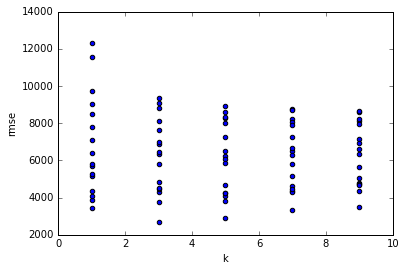

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
#we modify our function to take into account the k value
def knn_train_test(train_col, target_col, df, k):
    temp_df = df.copy()
    np.random.seed(1)
    temp_df = temp_df.loc[np.random.permutation(len(temp_df))]
    train_df = temp_df.iloc[0: (len(temp_df)//2)]
    test_df = temp_df.iloc[(len(temp_df)//2): ]
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(train_df[[train_col]], train_df[target_col])
    predictions = model.predict(test_df[[train_col]])
    mse = mean_squared_error(test_df[target_col], predictions)
    rmse = np.sqrt(mse)
    return(rmse)

k_vals = [1, 3, 5, 7, 9]
rmses = dict()
for column in feature_cols:
    col_rmses = dict()
    for k in k_vals:
        col_rmses[k] = knn_train_test(column, "price", cars, k)
    rmses[column] = col_rmses
    plt.scatter(list(col_rmses.keys()), list(col_rmses.values()))
    
plt.xlabel("k")
plt.ylabel("rmse")

Overall, the RMSEs seem relatively constant for the k values ranging from 3 to 9.

Next, we will see which features have the lowest overall rmse over all these k values.

In [15]:
avg_rmses = dict()
for k,v in rmses.items():
    avg_rmses[k] = np.mean(list(v.values()))
ser_avg_rmses = pd.Series(avg_rmses)
sorted_avg_rmses = ser_avg_rmses.sort_values()
print(sorted_avg_rmses)

engine_size          3175.483033
city_mpg             4067.817303
highway_mpg          4529.384314
width                4545.209688
horsepower           4662.638877
curb_weight          4677.979731
length               6042.332678
wheel_base           6171.881938
num_cylinders        6235.465248
compression_ratio    6738.323804
bore                 7285.083402
stroke               8269.469187
peak_rpm             8768.077244
symboling            8848.589647
num_doors            8942.229713
height               9073.977013
dtype: float64


##Multivariate k-nearest neighbors models

We will now use many features to train and test our machine learning models. We will use the best 2 to 6 features from the list above and see which model performs the best. For each number of features, we will calculate the average RMSE among from all the RMSEs when using every k value ranging from 3 to 9.

In [16]:
best_features = list(sorted_avg_rmses.keys())
print(best_features)

['engine_size', 'city_mpg', 'highway_mpg', 'width', 'horsepower', 'curb_weight', 'length', 'wheel_base', 'num_cylinders', 'compression_ratio', 'bore', 'stroke', 'peak_rpm', 'symboling', 'num_doors', 'height']


In [17]:
#we modify our function to take into account many feature columns and the avg rmse from k-values[3-9]
def knn_train_test(train_cols, target_col, df):
    
    temp_df = df.copy()
    
    np.random.seed(1)
    temp_df = temp_df.loc[np.random.permutation(len(temp_df))]
    train_df = temp_df.iloc[0: (len(temp_df)//2)]
    test_df = temp_df.iloc[(len(temp_df)//2): ]
    
    rmses = []
    
    #testing and training with 3 to 9 nearest neighbors
    k_vals = [k for k in range(3,10)]
    for k in k_vals:
        model = KNeighborsRegressor(n_neighbors = k)
        model.fit(train_df[train_cols], train_df[target_col])
        predictions = model.predict(test_df[train_cols])
        mse = mean_squared_error(test_df[target_col], predictions)
        rmse = np.sqrt(mse)
        rmses.append(rmse)
    
    #averaging from all RMSEs
    avg_rmse = np.mean(rmses)
    return(avg_rmse)

#finding the average rmse for various number of features
nb_ftr_avg_rmse = dict()

nb_features = [x for x in range(2,7)]
for n in nb_features:
    nb_ftr_avg_rmse[n] = knn_train_test(best_features[0:n], "price", cars)
    
print(nb_ftr_avg_rmse)
    

{2: 3182.319101698589, 3: 3348.2404365448892, 4: 3439.866516904499, 5: 3311.154588272336, 6: 3155.10583176089}


The three best models are the ones with 6, 2 and 5 of the previously ranked best features. Only the 6-feature model was able to beat the univariate model based on "engine_size". Because are models seem to be gaining precision with the 5th and 6th ranked features (horsepower and curb_weight), we will try models with our best feature "engine_size" and combinations of our 2nd ranked feature "city_mpg" and/or "horsepower" and/or "curb_weight".

In [18]:
print(best_features[0:2] + best_features[4:6])
print(knn_train_test(best_features[0:2] + best_features[4:6], "price", cars))
print(best_features[0:2] + ["horsepower"])
print(knn_train_test(best_features[0:2] + ["horsepower"], "price", cars))
print(best_features[0:2]+ ["curb_weight"] )
print(knn_train_test(best_features[0:2] + ["curb_weight"], "price", cars))
print(["engine_size"] + ["horsepower"])
print(knn_train_test(["engine_size"] + ["horsepower"], "price", cars))
print(["engine_size"] + best_features[4:6])
print(knn_train_test(["engine_size"] + best_features[4:6], "price", cars))
print(["engine_size"] + ["curb_weight"])
print(knn_train_test(["engine_size"] + ["curb_weight"], "price", cars))

['engine_size', 'city_mpg', 'horsepower', 'curb_weight']
3498.3354270029313
['engine_size', 'city_mpg', 'horsepower']
3249.3779408881123
['engine_size', 'city_mpg', 'curb_weight']
3515.321851766369
['engine_size', 'horsepower']
3307.7962912753796
['engine_size', 'horsepower', 'curb_weight']
3527.8020136071377
['engine_size', 'curb_weight']
3486.4469347905447


The ['engine_size', 'city_mpg', 'horsepower'] model entered our top 3 of lowest RMSEs. We will use it along with our 2-feature and 6-feature models based on our ranked columns.

##Hyperparameter optimisation

Using our best 3 models, we will try to optimize the number of nearest neighbors (the k value) to use for our k-nearest neighbor regressions.

In [19]:
#we modify our function again to be able to specify the k value
def knn_train_test(train_cols, target_col, df, k):
    
    temp_df = df.copy()
    
    np.random.seed(1)
    temp_df = temp_df.loc[np.random.permutation(len(temp_df))]
    train_df = temp_df.iloc[0: (len(temp_df)//2)]
    test_df = temp_df.iloc[(len(temp_df)//2): ]

    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(train_df[train_cols], train_df[target_col])
    predictions = model.predict(test_df[train_cols])
    mse = mean_squared_error(test_df[target_col], predictions)
    rmse = np.sqrt(mse)
    
    return(rmse)

####Model 1 : Two best features ["engine_size", "city_mpg"]

{1: 2924.9549426729063, 2: 2574.8943298504178, 3: 2764.2025939362825, 4: 2886.626223652471, 5: 2888.757787238891, 6: 2934.6937630574403, 7: 3293.9329978272435, 8: 3626.8418746063962, 9: 3881.178471571399, 10: 4092.5023872295014, 11: 4246.4630918520215, 12: 4314.874624024474, 13: 4339.881128080336, 14: 4420.305430950575, 15: 4462.228683727407, 16: 4514.781417639632, 17: 4606.006221512096, 18: 4684.73493874961, 19: 4803.883449239475, 20: 4872.229293171082, 21: 4965.371982859882, 22: 5009.206771478388, 23: 5005.011083709456, 24: 5020.394619869478, 25: 5113.027147638015}


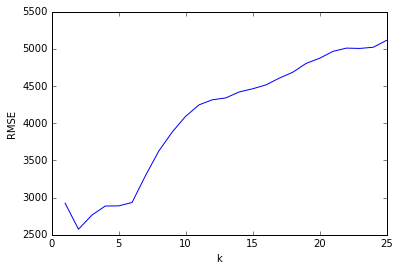

In [23]:
#trying k values from 1 to 25
k_vals = [k for k in range(1, 26)]
model_1_cols = best_features[0:2]
model_l_rmses = dict()
for k in k_vals:
    model_l_rmses[k] = knn_train_test(model_1_cols, "price", cars, k)
plt.plot(list(model_l_rmses.keys()), list(model_l_rmses.values()))
plt.xlabel("k")
plt.ylabel("RMSE")
print(model_l_rmses)

For the first model, the best-performing k value is 2. We can see that the model starts losing precision quickly when we use a k value of 7 or more. This could be an indication that a car in our test set doesn't have many similar cars in our 96-row training set so that the 7th nearest neighbor and more doesn't give a good price approximation.

####Model 2 : Three features ["engine_size", "city_mpg", "horsepower"]

['engine_size', 'city_mpg', 'horsepower']
{1: 3095.6636320693283, 2: 2653.1701301619037, 3: 2660.15801796727, 4: 2702.315898900037, 5: 2794.5330559564572, 6: 3157.7415609300583, 7: 3544.652563138925, 8: 3792.662536815537, 9: 4093.581952508499, 10: 4400.872142660096, 11: 4503.034030797913, 12: 4572.871010426032, 13: 4679.993905807461, 14: 4741.385100673091, 15: 4769.973719412811, 16: 4868.2697819827135, 17: 5041.099660935741, 18: 5074.215996376255, 19: 5103.590417018115, 20: 5107.486130299124, 21: 5144.010702450984, 22: 5175.774023132072, 23: 5191.799765791191, 24: 5205.140778122507, 25: 5249.056288727845}


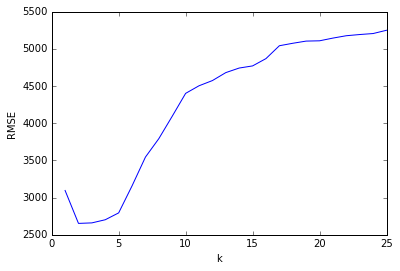

In [26]:
model_2_cols = best_features[0:2] + ["horsepower"]
print(model_2_cols)
model_2_rmses = dict()
for k in k_vals:
    model_2_rmses[k] = knn_train_test(model_2_cols, "price", cars, k)
plt.plot(list(model_2_rmses.keys()), list(model_2_rmses.values()))
plt.xlabel("k")
plt.ylabel("RMSE")
print(model_2_rmses)

Again with this model, the best predictions come from when k=2. It starts losing precision quickly when k=6 or more.

####Model 3: Six best features ['engine_size', 'city_mpg', 'highway_mpg', 'width', 'horsepower', 'curb_weight']

{1: 2833.8233577477386, 2: 2608.6290785143897, 3: 2504.2208285878733, 4: 2527.1903778166707, 5: 2792.7336315278385, 6: 3167.295907831506, 7: 3464.6160156111455, 8: 3677.909622119141, 9: 3951.774438832052, 10: 4153.79136256866, 11: 4394.757221154051, 12: 4567.437399137247, 13: 4691.963583115921, 14: 4829.929307399544, 15: 4935.623946437588, 16: 4930.939693690989, 17: 4921.658275166599, 18: 4908.94822530806, 19: 4902.646475281891, 20: 4975.364547295965, 21: 4988.029595736679, 22: 5086.925722176825, 23: 5114.580779034599, 24: 5194.867410027815, 25: 5187.124464946835}


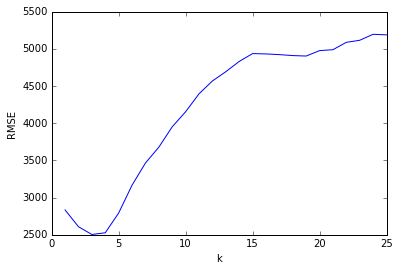

In [28]:
model_3_cols = best_features[0:6]
model_3_rmses = dict()
for k in k_vals:
    model_3_rmses[k] = knn_train_test(model_3_cols, "price", cars, k)
plt.plot(list(model_3_rmses.keys()), list(model_3_rmses.values()))
plt.xlabel("k")
plt.ylabel("RMSE")
print(model_3_rmses)

With this model, we achieve our lowest RMSE over all our models when k=3, with a RMSE of 2504$. Like for the second model, the RMSE rises above 3000 when k reaches 6 and rises significantly after that.

##K-Fold cross validation

The last step of our project will be to verify that our results aren't too biased by the 50/50 random split between our training and testing data that we have been using so far. To do that, we will perform a k-fold cross validation on our best model so far : the 6-feature model. We will use 2 nearest neighbors instead of 3, because it was performing better across the three tested feature combinations above.

Because we want the model to make at least around 40 predictions per test set and we have 192 rows of data, we will split the data in 5 folds. The cross validation technique will return a list of 5 mean squared errors, one for every fifth of the data used as a test set (the other 4/5 being used for training).

In [47]:
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle=True, random_state=1)
model = KNeighborsRegressor(n_neighbors = 3)
mses = cross_val_score(model, cars[model_3_cols], cars["price"], scoring="neg_mean_squared_error", cv=kf)
rmses = np.abs(mses) ** (1/2)
print(rmses)
avg_rmse = np.mean(rmses)
print(avg_rmse)

[3487.15821136 3926.09140632 1679.1688714  2625.88032858 1924.68603728]
2728.5969709865526


The cross-validation gives us an average RMSE of around 2729 over our 5 test sets. It is not too far from our 2504 minimal value found with the 50/50 split, and even closer to the 2608 value we had when using 2 nearest neighbors as we did to do the cross validation. This confirms that our initial 50/50 random split was valid and did not cause major errors in our calculations.

##Conclusion

In this project, a K-Nearest Neighbors machine learning model to train and test our dataset of car specifications in order to predict car prices. We started by identifying the features that allowed our model that make the most precise predictions. Then, we combined our best features in various combinations to find to best multivariate models. The most promising model turned out to be the one using our best six features: ['engine_size', 'city_mpg', 'highway_mpg', 'width', 'horsepower', 'curb_weight']. This can be due to the wide variety of cars in our dataset, and more generally in the automotive world. We know that for example, almost every type of vehicle (ex. sedan, van, SUV) has both luxury and more affordable existing vehicles. This can explain why we might need as much as six features to precisely evaluate which cars have similar prices : both the type and the luxury level of a car modulates its price. After determining our best multivariate models, we tested many values of k, the number of nearest neighbors our model uses. We found out that it performs better using only 2 or 3 nearest neighbors from the training set. This might be due to our dataset potentially having many groups of 3 or 4 similar cars and that by using cars outside of their top 3 neighbors we might in fact use a very different car. At the end, we confirmed that the training and testing groups we have been using from the start were not too biased by doing a 5-fold cross validation using our 6-feature model with 2 nearest neighbors.